# Study group 5's first level analysis

The chunks are copied from the 13_nilearn_faceWord_stats.ipynb tutorial 

### In this tutorial, we will:

1. Download an fMRI `BIDS` dataset with two conditions to contrast (word and face trials).
2. Extract first level (single subject) model objects automatically from the `BIDS` dataset.
3. Investigate the model and plot it design matrix, contrasts and effects.

### What should be done next (in another notebook) - second level analysis
1. Apply a mask (ROI); look here https://lukas-snoek.com/NI-edu/fMRI-introduction/week_6/ROI_analysis.html 
2. Train classifier
3. Look at accuracies and the activation within the ROI
4. Permutation test

In [2]:
# import some functionality
from datetime import datetime

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))
import os
import pip
os.system('python3 -m pip install numpy')
os.system('python3 -m pip install matplotlib')
os.system('python3 -m pip install scipy')
os.system('python3 -m pip install panda')
os.system('python3 -m pip install nilearn')
os.system('python3 -m pip install pickle')
os.system('python3 -m pip install atlasreader')

#import os.path as op
#import numpy as np
#from numpy.linalg import inv
#import nibabel as nib
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter

%matplotlib inline

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Starting cell: 14:59:09
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Finishing cell: 14:59:18


## Fetch faceWord BIDS dataset
The faceWord dataset is located in the `fMRI_data_raw` folder.


In [3]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
data_dir='/work/fMRI Assignment/BIDS/' 
derivatives_dir=  '/work/fMRI Assignment/BIDS/derivatives/'          
list_files(derivatives_dir)

/
    .bidsignore
    dataset_description.json
    sub-0054.html
    sub-0057.html
    sub-0058.html
    sub-0059.html
    sub-0060.html
    sub-0062.html
    sub-0064.html
    sub-0065.html
    sub-0066.html
    sub-0077.html
    sub-0078.html
    sub-0079.html
    sub-0080.html
    sub-0081.html
    sub-0083.html
    sub-0084.html
    sub-0090.html
    sub-0091.html
    sub-0092.html
    sub-0093.html
    sub-0094.html
    sub-0096.html
sub-0054/
    figures/
        sub-0054_acq-T1sequence_run-1_desc-conform_T1w.html
        sub-0054_acq-T1sequence_run-1_dseg.svg
        sub-0054_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_T1w.svg
        sub-0054_desc-about_T1w.html
        sub-0054_desc-summary_T1w.html
        sub-0054_task-EPIsequencewords_run-1_desc-carpetplot_bold.svg
        sub-0054_task-EPIsequencewords_run-1_desc-compcorvar_bold.svg
        sub-0054_task-EPIsequencewords_run-1_desc-confoundcorr_bold.svg
        sub-0054_task-EPIsequencewords_run-1_desc-flirtbbr_bold.svg

### What is in the BIDS folder?
This `BIDS` dataset folder contains different mandatory elements ([http://bids.neuroimaging.io](http://bids.neuroimaging.io/)). These include:
- A folder for each participant, e.g. `sub-01`. This contains a subfolder called `func` where the raw BOLD data is usually stored along with a `.tsv` file describing the events (experimental design) of the particular scan. In this dataset the raw data has been left out. Also the `anat`folder, which normally contains anatomical scans have been left out.
- A folder called `derivatives` which is used to store processed data. In this dataset, we will can find preprocessed data files `preproc_bold.nii` and the `confounds_regressors.tsv` files (which contains the motion parameters from the spatial realignment. 
- A number of `.json` files with meta-data.

NB. All the filenames contain a description of the particular experiment.

## Obtain automatically FirstLevelModel objects and fit arguments
From the dataset directory we automatically obtain the FirstLevelModel objects
with their subject_id filled from the :term:`BIDS` dataset. Moreover, we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the :term:`BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label (`languagelocalizer`) as specified in the file names.

In [4]:
from nilearn.glm.first_level import first_level_from_bids

# #BIDS directory
# data_dir='/work/82777/BIDS/'
# # BIDS derivatives (contains preprocessed data)
# derivatives_dir='/work/82777/BIDS/derivatives' 
# Name for experiment in the BIDS directory
task_label = 'EPIsequencewords'
# Label for data that are spatially aligned to the MNI152 template (i.e. spatially normalised)
space_label ='MNI152NLin2009cAsym'
#Run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=6, verbose=1,
        img_filters=[('desc', 'preproc')])

#Print the data from the first participant as sanity check
print(models_run_imgs[0])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:940: UserWarning: SliceTimingRef not found in file /work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


['/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-5_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI Assignment/BIDS/derivatives/sub-0054/func/sub-0054_task-EPIsequencewords_run-6_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Finishing cell: 14:59:34


### What just happened?

The above code looks somewhat opaque. What is happening here? Let's look into the `first_level_from_bids` function.

In [5]:
#What does the `first_level_from_bid` function take as arguments?
import inspect
import pandas as pd
#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)

#Same info can also be obtained by writing first_level_from_bids?

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

                                        0
space_label                          None
img_filters                          None
t_r                                  None
slice_time_ref                        0.0
hrf_model                          glover
drift_model                        cosine
high_pass                            0.01
drift_order                             1
fir_delays                            [0]
min_onset                             -24
mask_img                             None
target_affine                        None
target_shape                         None
smoothing_fwhm                       None
memory              Memory(location=None)
memory_level                            1
standardize                         False
signal_scaling                          0
noise_model                           ar1
verbose                                 0
n_jobs                                  1
minimize_memory                      True
derivatives_folder            deri

Here, we can see that the function uses information about `t_r` (TR), `HRF_model` (hemodynamic response function),``drift_model`` and `high_pass` (both used for high-pass filtering), `noise_model`(used for modelling auto correlation). In other words, this function seems to implement all the elements, we have been going through in previous tutorials.

<b>Nice stuff!</b>

## Quick sanity check on fit arguments
Additional checks or information extraction from pre-processed data can
be made here.



As, we have seen from the folder inspection, we only have one run_img per subject.

Sigrid's comment; how do we see that.... 

In [6]:
import os
#Get the file names for subj01 functional data
func01=([os.path.basename(run) for run in models_run_imgs[12]])
print(func01)


['sub-0080_task-EPIsequencewords_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0080_task-EPIsequencewords_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0080_task-EPIsequencewords_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0080_task-EPIsequencewords_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0080_task-EPIsequencewords_run-5_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0080_task-EPIsequencewords_run-6_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


Let's load this file and inspect the data.

In [7]:
from nilearn import image

#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

func_img.header.get_zooms()

Shape of functional MRI image: (78, 92, 65, 3600)


(2.526, 2.526, 3.0, 1.0)

As we see, the data contains 6x600 = 3600 volumes with a 78 x 92 x65 voxel resolution.

In [16]:
print(models[0])
print(type(func_img))

FirstLevelModel(n_jobs=6, subject_label='0054', t_r=1.0, verbose=1)
<class 'nibabel.nifti1.Nifti1Image'>


Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

Here, we see the additional information that data were obtained with a TR of 1.0 seconds.

fmriprep exports a large number of [confounding parameters](https://fmriprep.org/en/stable/outputs.html#confounds) which can be used to regress out noise in the data. These are saved in a .tsv file in the derivatives folder (func) with the name `sub-00xx_task-EPIsequencewords_run-1_desc-confounds_timeseries.tsv`.

These are automatically imported into the `model_confounds` variable.
Let's inspect what we find in the `models_confounds` variable.

In [17]:
#Print model confounds for first participant, first run
print(models_confounds[0][0].columns)

Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_power2', 'csf_derivative1_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'rot_z_derivative1_power2', 'motion_outlier00', 'motion_outlier01',
       'motion_outlier02', 'motion_outlier03', 'motion_outlier04',
       'motion_outlier05', 'motion_outlier06', 'motion_outlier07',
       'motion_outlier08'],
      dtype='object', length=378)


There are literally hundreds of confounds stored.
Read more about them [here](https://fmriprep.org/en/stable/outputs.html#confounds)

Read more about how they can be used in [this article](https://www.sciencedirect.com/science/article/pii/S1053811917310972?via%3Dihub)
Here, we will pick the Friston24 confound variables. These correspond to the rotations and translations, we covered in the <tt>08_fMRI_preprocessing2_spatial.ipyn</tt> tutorial in combination with their derivatives and their squares. We will combine them with four measures of the global signal.

In [18]:

confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1


#Print new confounds, for first participant, first run
print(models_confounds[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1',
       'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1',
       'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2',
       'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2'],
      dtype='object')
Finishing cell: 13:31:09


### Events from the experiment
Next, we will see what is in the `models_events` variable.

In [19]:
print(models_events[0][0])

          onset  duration trial_type  response_time       word gender  age  \
0      4.697693  0.671809  image_neg       1.055635        man   male   26   
1     17.293148  0.676945  image_pos       0.610639      whale   male   26   
2     24.695765  0.674699  image_neg       0.841728       gasp   male   26   
3     37.292052  0.679036  image_neg       0.595988    tourist   male   26   
4     47.289443  0.682034  image_neg       0.732626  alligator   male   26   
..          ...       ...        ...            ...        ...    ...  ...   
115  551.013569  0.697452   word_pos       0.597385     garden   male   26   
116  561.014209  0.697259   word_neg       0.676520      mouse   male   26   
117  571.016477  0.695576   word_neg       0.631291  policeman   male   26   
118  581.015185  0.697195   word_neu       0.842529     famous   male   26   
119  591.015719  0.697092   word_neu       0.548823     tomato   male   26   

     sub              task  run  year  month  day  hour  minute

We will trim this a bit as well, to avoid some annoying error messages

In [20]:
#Print model confounds for first participant, first run
print(models_events[0][0].columns)

events_sub= ['onset','duration','trial_type']



# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1


#Print new confounds, for first participant, first run
print(models_events[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['onset', 'duration', 'trial_type', 'response_time', 'word', 'gender',
       'age', 'sub', 'task', 'run', 'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')
Index(['onset', 'duration', 'trial_type'], dtype='object')
Finishing cell: 13:31:26


We can see check how many trials were in each condition:

In [21]:
# first subject, first session
print(models_events[0][0]['trial_type'].value_counts())

image_pos    32
image_neg    28
word_neu     20
word_neg     20
word_pos     20
Name: trial_type, dtype: int64


60 trials!

## First level (single subject) model estimation
Now, that we have seen that the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis


### Analysing one participant

We will start by analysing the data from the first participant and generating a report of the process and the results.

If we have a [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) class object as we have created above, we can use the variable.fit() function to pair the `FirstLevelModel`object with the missing information (e.g. functional images, events and a matrix of confounding variables), assemble the model and estimate it.

In [22]:

# Get data and model info for 1st participant
model1=models[0]
imgs1=models_run_imgs[0]
events1=models_events[0]
confounds1=models_confounds[0]

#Fit the model
model1.fit(imgs1,events1,confounds1)
#model1.zmap=model1.compute_contrast('image_neg-image_pos')
model1.zmap=model1.compute_contrast('word_pos+word_neg+word_neu-image_neg-image_pos')


now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Computing run 1 out of 6 runs (go take a coffee, a big one)
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/pytho

Finishing cell: 13:33:46


### Plotting the design matrix
We will then use the `plot_design_matrix`function to give the model a sanity check. 

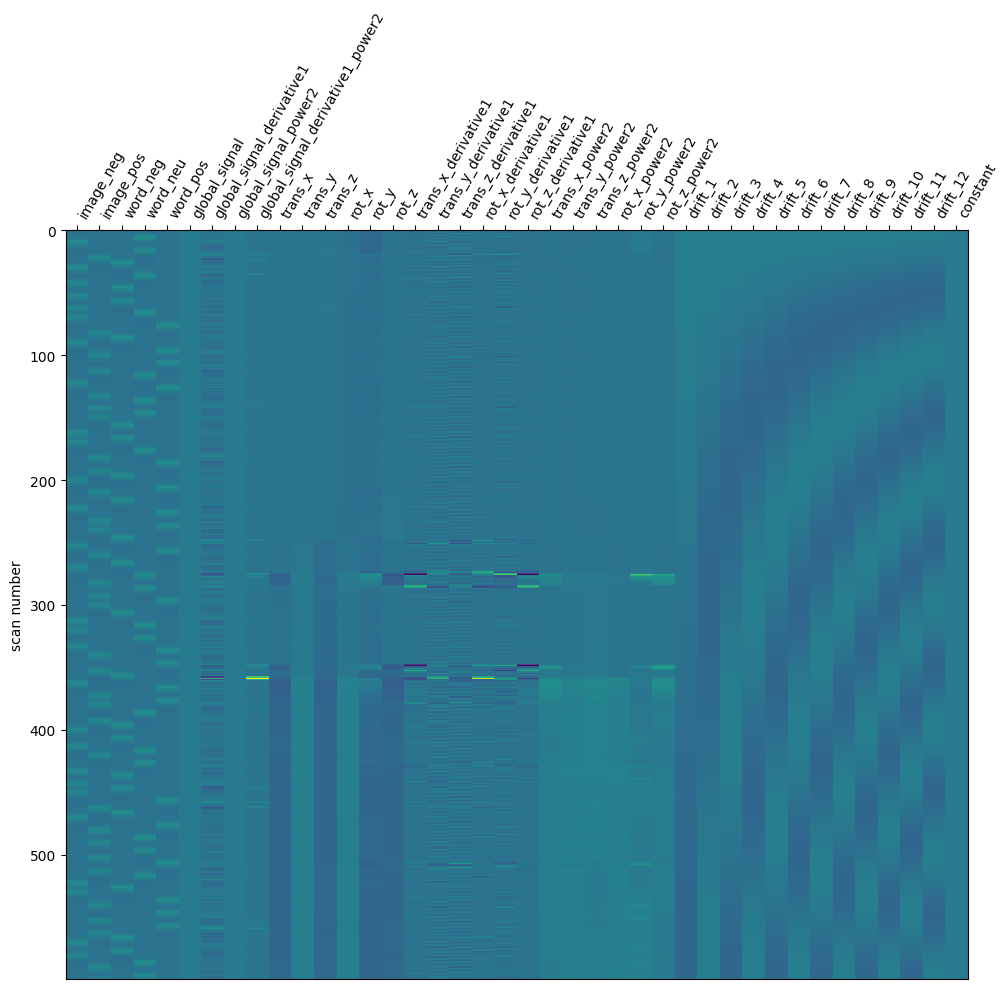

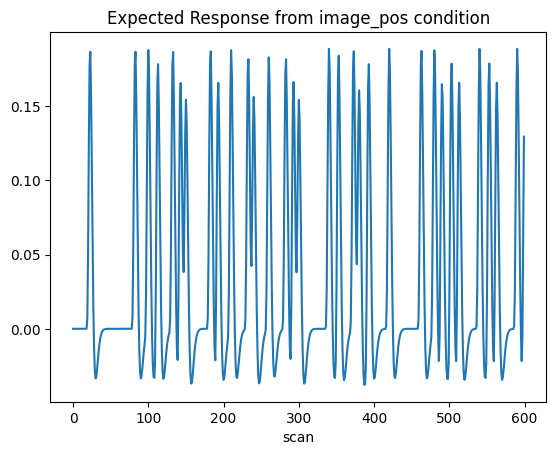

Finishing cell: 13:34:10


In [23]:

from nilearn.plotting import plot_design_matrix

# View the design matrix
design_matrix = model1.design_matrices_[0]


#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Also plot time series
plt.plot(design_matrix['image_pos'])
plt.xlabel('scan')
plt.title('Expected Response from image_pos condition')
plt.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

We see that the design matrix contains 2 columns for the conditions + 6 for the motion parameters + 6 cosine functions for high-pass filtering + one constant/intercept.

When plotting the expected response function, we see that it looks like the hemodynamic response function.


### Defining contrasts


Next, we need to specify the `contrasts` that we are interested in. These can be defined using using vectors or the names of of the conditions, specified in the events dataframe. Sum, subtraction and scalar multiplication are allowed.


Finishing cell: 13:45:17


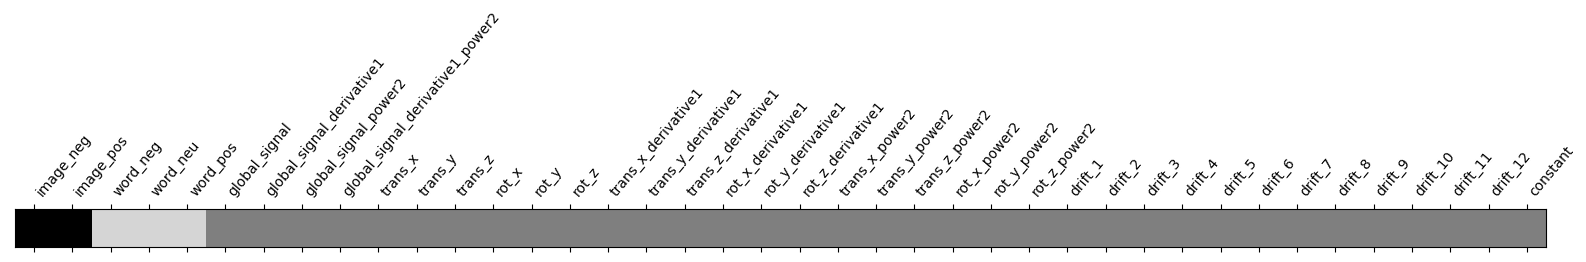

In [36]:
from nilearn.plotting import plot_contrast_matrix

#Define contrasts
#contrasts=['image_pos','image_neg','image_pos+image_neg','image_neg-image_pos']
contrasts = ['word_pos+word_neg+word_neu-image_pos*1.5-image_neg*1.5']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix=design_matrix)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Setting the significance threshold
To display the results, we will set a statistical threshold. Conventionally p<0.001, uncorrected for multiple comparisons has been used. 

It often gives a good picture of what is at play in the data, but should be interpreted with caution, due to the fact that it is uncorrected.

In [37]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

### Plotting the results
Now, we will plot the results from the different contrasts. We will do so using the mean of the functional data as background.

/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


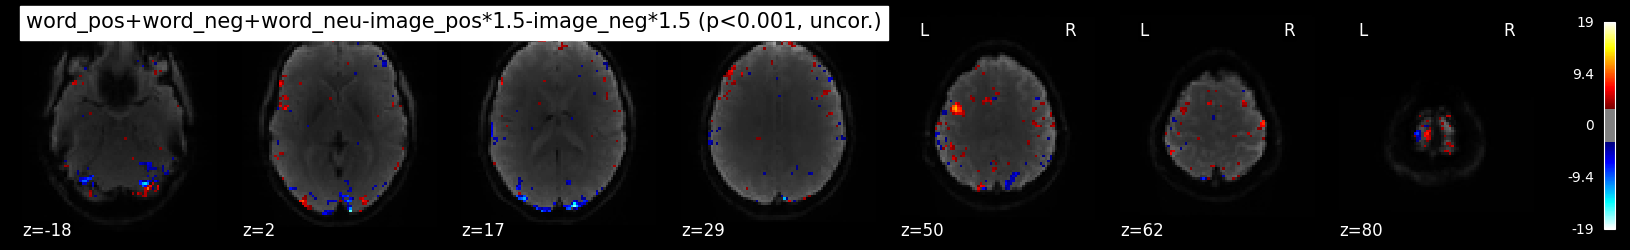

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1 -40.927999   -1.147999  50.5  11.902328               2029
1          1a -30.823999   -1.147999  65.5   5.744956                   
2           2  29.800001  -81.980000 -18.5   9.550625                516
3          2a  27.274001  -89.558000 -15.5   7.142198                   
4          2b  19.696001  -87.032000 -18.5   4.903710                   
5           3 -10.615999    8.956001  38.5   9.159961                976
6          3a  -5.563999    6.430001  53.5   6.828556                   
7          3b  -8.089999    8.956001  44.5   5.424521                   
8          3c  -5.563999    3.904001  65.5   5.333078                   
9           4 -35.875999  -94.610000   2.5   9.050029               1588
10         4a -43.454000  -89.558000  -3.5   7.091545                   
11         4b -28.297999  -89.558000 -12.5   6.415906                   
12         4c -30.823999 -102.188000  -0.5   6.0977

In [38]:
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img


# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score')


    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Make a report of the results

We can also use the [`make_glm_report`](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html) function to make a report in one go. This report is generated as a HTML document, which can only be viewed in a notebook.

This also includes a table of cluster coordinates.


In [39]:
from nilearn.reporting import make_glm_report
#Generate a report
report = make_glm_report(model1,
                         contrasts=contrasts,
                         threshold=p001_unc,
                         bg_img=mean_img_,
                         )
#Display report in HTML format
report

/home/coder/.local/lib/python3.9/site-packages/nilearn/reporting/utils.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/home/coder/.local/lib/python3.9/site-packages/nilearn/reporting/utils.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/home/coder/.local/lib/python3.9/site-packages/nilearn/reporting/utils.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/home/coder/.local/lib/python3.9/site-packages/nilearn/reporting/utils.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/home/coder/.local/lib/python3.9/site-packages/nilearn/reporting/utils.py:8: UserWarning: Tight layout not a

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,0
slice_time_ref,0.0
smoothing_fwhm,None
standardize,False


### Making an F contrast


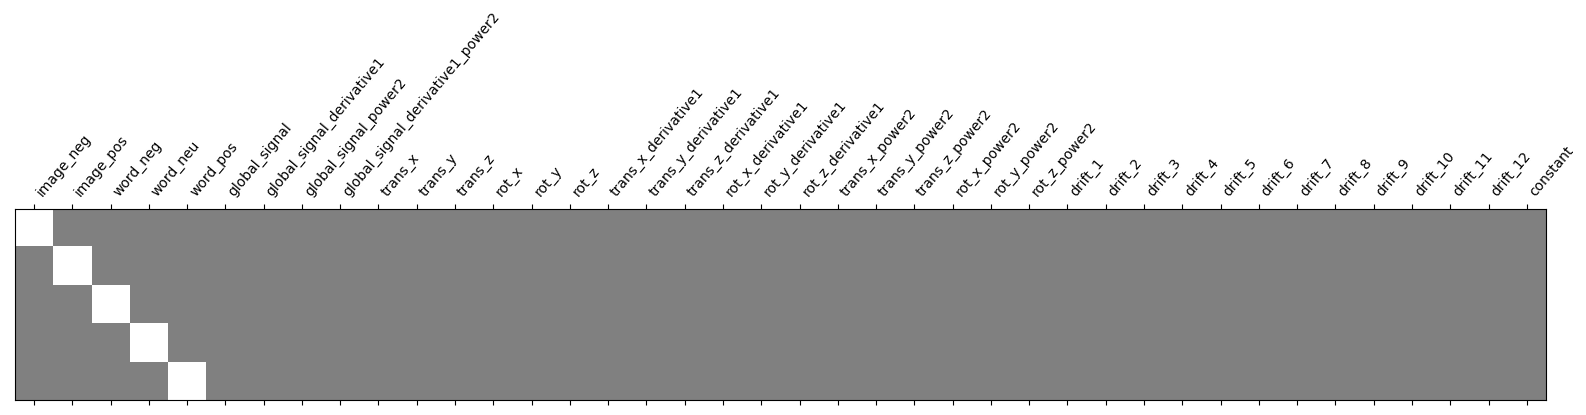

/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/contrasts.py:353: UserWarning: Running approximate fixed effects on F statistics.
  warn('Running approximate fixed effects on F statistics.')


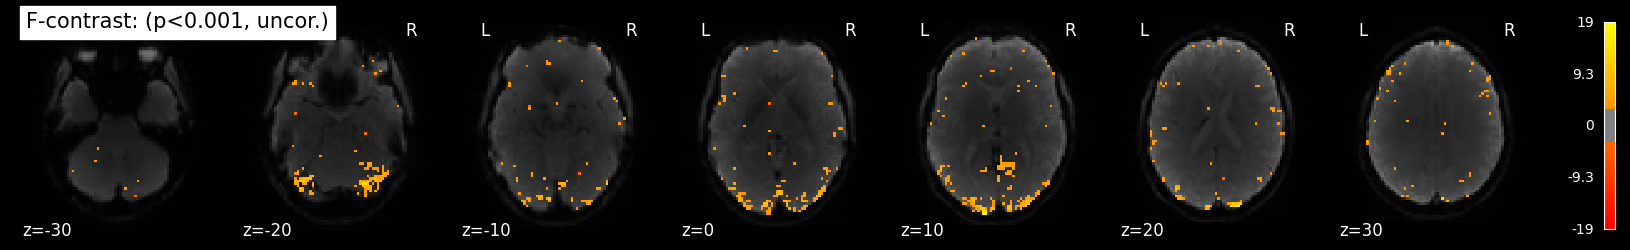

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1  -8.089999  -99.662000  23.5  18.624135               4996
1          1a -10.615999 -107.240000   8.5  17.351732                   
2          1b -33.349999  -92.084000  17.5  13.585133                   
3          1c -28.297999  -97.136000  11.5  12.898538                   
4           2  17.170001  -99.662000  17.5  17.408644               5512
5          2a  12.118001 -104.714000   2.5  16.402548                   
6          2b   9.592001 -102.188000  14.5  14.700065                   
7          2c  44.956001  -84.506000  -3.5  13.341444                   
8           3  27.274001  -76.927999 -18.5  13.890855               2029
9          3a  17.170001  -79.454000 -15.5   8.557718                   
10         3b  37.378001  -71.875999 -18.5   8.063520                   
11         3c  27.274001  -89.558000 -15.5   7.535972                   
12          4 -40.927999   -1.147999  50.5  12.1532

In [40]:
import numpy as np

#create a contrast matrix for the F-contrast, spanning the two first columns in the design matrix
effects_of_interest =np.identity(design_matrix.shape[1])[[0,1,2,3,4],:]

#Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

#Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

#And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()
    
# Make a table of cluster coordinates.
table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
print(table)

### Analysing all single participants in one go and plotting them

Now, we will make a loop which fits all the models and plots the results. We will focus on the `image_neg-image_pos` contrast.



Starting cell: 13:47:49


Computing run 1 out of 6 runs (go take a coffee, a big one)
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/coder/.local/lib/pytho

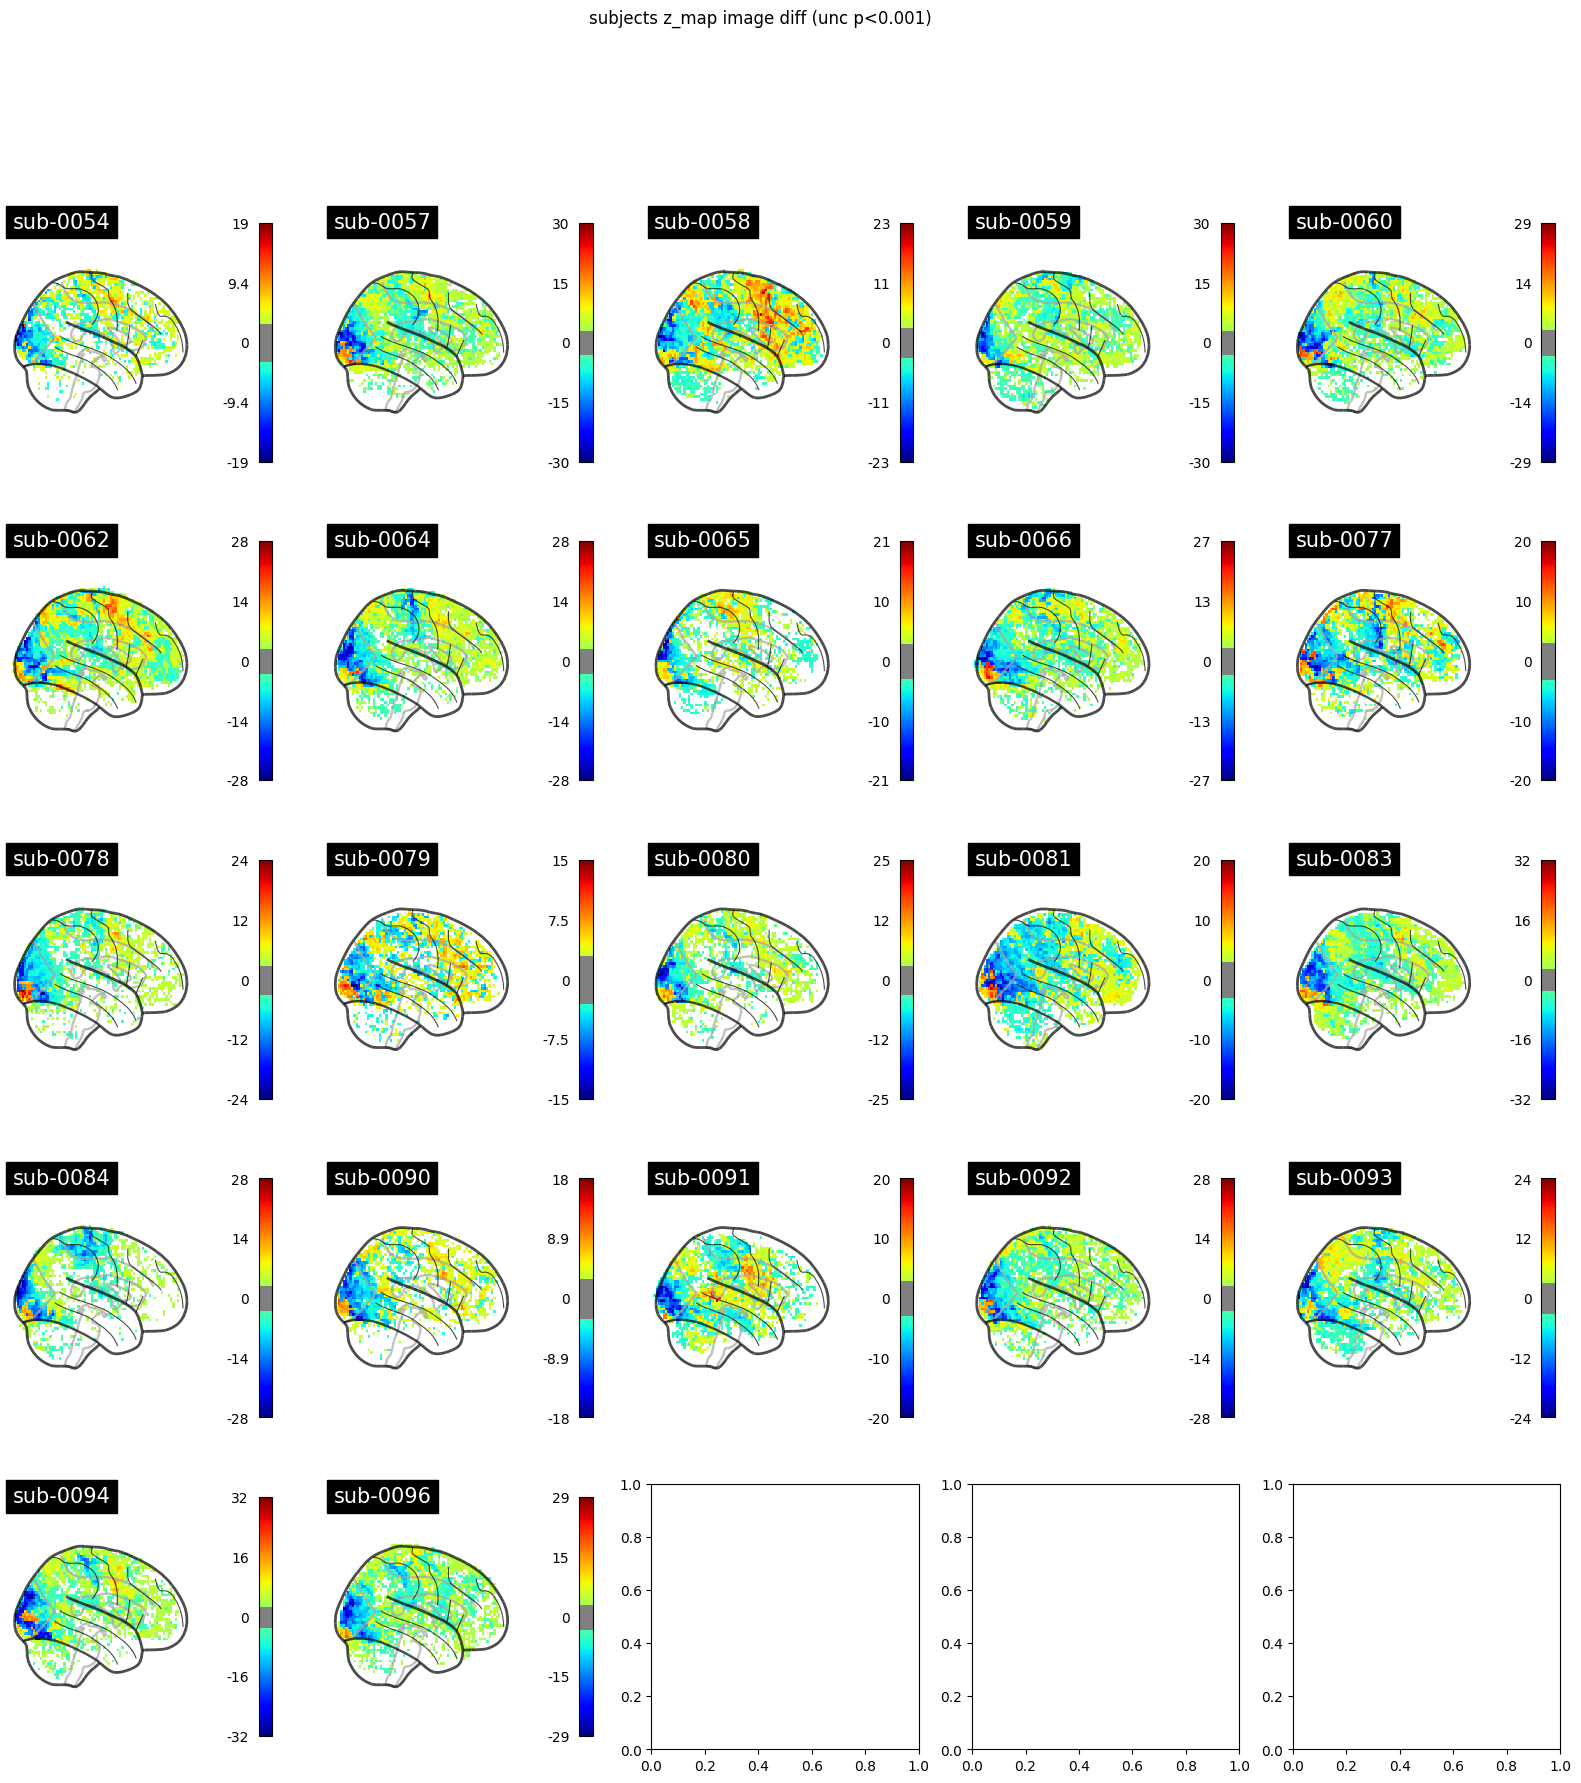

Finishing cell: 14:29:03


In [41]:
from nilearn import plotting
import matplotlib.pyplot as plt

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20)) 
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    model.zmap = model.compute_contrast(contrasts)
    #Plot each thresholded analysis
    plotting.plot_glass_brain(model.zmap, cmap='jet',colorbar=True, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 5), int(m_idx % 5)],
                              plot_abs=False, display_mode='x')

   
fig.suptitle('subjects z_map image diff (unc p<0.001)')
plotting.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

#### Same but different
Note that the single subject results look very different, although one can also see patterns in most participants that look similar.

## Saving results.

The analysis took a bit of time. Let's make sure to save the results, so that we don't have to run that again. 

#### Remember to change the directory to somewhere convenient.

In [42]:
import pickle

#Save the first level models

# Saving the objects:
#f = open('/work/MikkelWallentin#6287/WordFace_first_level_models.pkl', 'wb')
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_our_contrast.pkl', 'wb')
pickle.dump([models, models_run_imgs, models_events, models_confounds], f)
f.close()

# Getting back the objects:
#f = open('store.pckl', 'rb')
#models, models_run_imgs, models_events, models_confounds = pickle.load(f)
#f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 14:32:11


In [ ]:

# Getting back the objects:
f = open('/work/fMRI Assignment/neuro_exam/fMRI_data_analyzed/WordFace_first_level_our_contrast.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()
